<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/reservoir/simplereservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simplified reservoir simulation model
In this section we will use a simplified reservoir simulation model based in constant volume - temperature flashes. This will be used for developing fluid input to further gas processing calculations.

This document is part of the module "Introduction to Gas Processing using NeqSim in Colab".

In [1]:
!pip install neqsim -q
import neqsim
from neqsim.thermo.thermoTools import *
from neqsim.process.processTools import simplereservoir, run, clearProcess
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 17.7 MB/s eta 0:00:00


In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# High-res inline figures in Colab
mpl.rcParams['figure.dpi'] = 160          # how it is drawn in the output
mpl.rcParams['savefig.dpi'] = 300         # if you save it
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.grid'] = True

# Reservoir simulation - the tank model
One of the representations of reservoir models is called the Tank Model, is also called "the building block of reservoir simulators", it is a zero dimensional model, because just like in the example of the oil MBE equation, the difference between the initial oil and the final oil entering the reservoir is the Cumulative net withdrawal. The tank model takes the average values for the whole properties of the reservoir by assuming that there is no oil entering the reservoir. However, the tank model cannot represent sandbars and average them out as a whole due to variation of lithology, but instead it can average out the components within. In this case, because of the expansion of fluids complications, the MBE equation together with Darcy's Law are used to describe the behavior of each component. This new model is a one- dimensional simulator because it has more than one component in one direction and one component in the other two directions.

Ref.: https://wiki.seg.org/wiki/Reservoir_simulation

In [7]:
fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 0.100)
fluid1.addComponent("CO2", 0.100)
fluid1.addComponent("methane", 30.00)
fluid1.addComponent("ethane", 1.0)
fluid1.addComponent("propane", 1.0)
fluid1.addComponent("i-butane", 1.0)
fluid1.addComponent("n-butane", 1.0)
fluid1.addComponent("n-hexane", 0.1)
fluid1.addComponent("n-heptane", 0.1)
fluid1.addComponent("n-nonane", 1.0)
fluid1.addComponent("nC10", 1.0)
fluid1.addComponent("nC12", 3.0)
fluid1.addComponent("nC15", 3.0)
fluid1.addComponent("nC20", 3.0)
fluid1.addComponent("water", 11.0)
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)

fluid1.setPressure(100.0, 'bara')
fluid1.setTemperature(100.0, 'C')

TPflash(fluid1)

clearProcess()

reservoirOps = simplereservoir("Well 1 reservoir",fluid1,  gasvolume=5.0 * 1e7, oilvolume=552.0 * 1e6, watervolume=10.0e6)

producedGasStream = reservoirOps.addGasProducer("SLP_A32562G")
producedGasStream.setFlowRate(0.01, "MSm3/day")

injectionGasStream = reservoirOps.addGasInjector("SLP_A32562GI")
fluidComposition(injectionGasStream.getFluid(), [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0])
injectionGasStream.setFlowRate(1.1, "MSm3/day")

injectionWaterStream = reservoirOps.addWaterInjector("SLP_A32562W")
injectionWaterStream.setFlowRate(10000000.1, "kg/day")

producedOilStream = reservoirOps.addOilProducer("SLP_A32562O")
producedOilStream.setFlowRate(50000000.0, "kg/day")


deltat = 24*60*60.0*365
time = []
pressure = []
gasvolume = []
watervolume = []
oilvolume = []
wateringas = []
totalproducedoe = []
co2reservoirgas = []

for t in range(10):
    reservoirOps.runTransient(deltat)
    time.append(t*deltat/(24*60*60.0*365))
    pressure.append(reservoirOps.getReservoirFluid().getPressure('bara'))
    gasvolume.append(reservoirOps.getReservoirFluid().getPhase("gas").getVolume("m3"))
    oilvolume.append(reservoirOps.getReservoirFluid().getPhase("oil").getVolume("m3"))
    watervolume.append(reservoirOps.getReservoirFluid().getPhase("aqueous").getVolume("m3"))
    wateringas.append(reservoirOps.getReservoirFluid().getPhase("gas").getComponent('water').getx())
    totalproducedoe.append(reservoirOps.getProductionTotal('MSm3 oe'))
    co2reservoirgas.append(reservoirOps.getReservoirFluid().getComponent('CO2').getz())

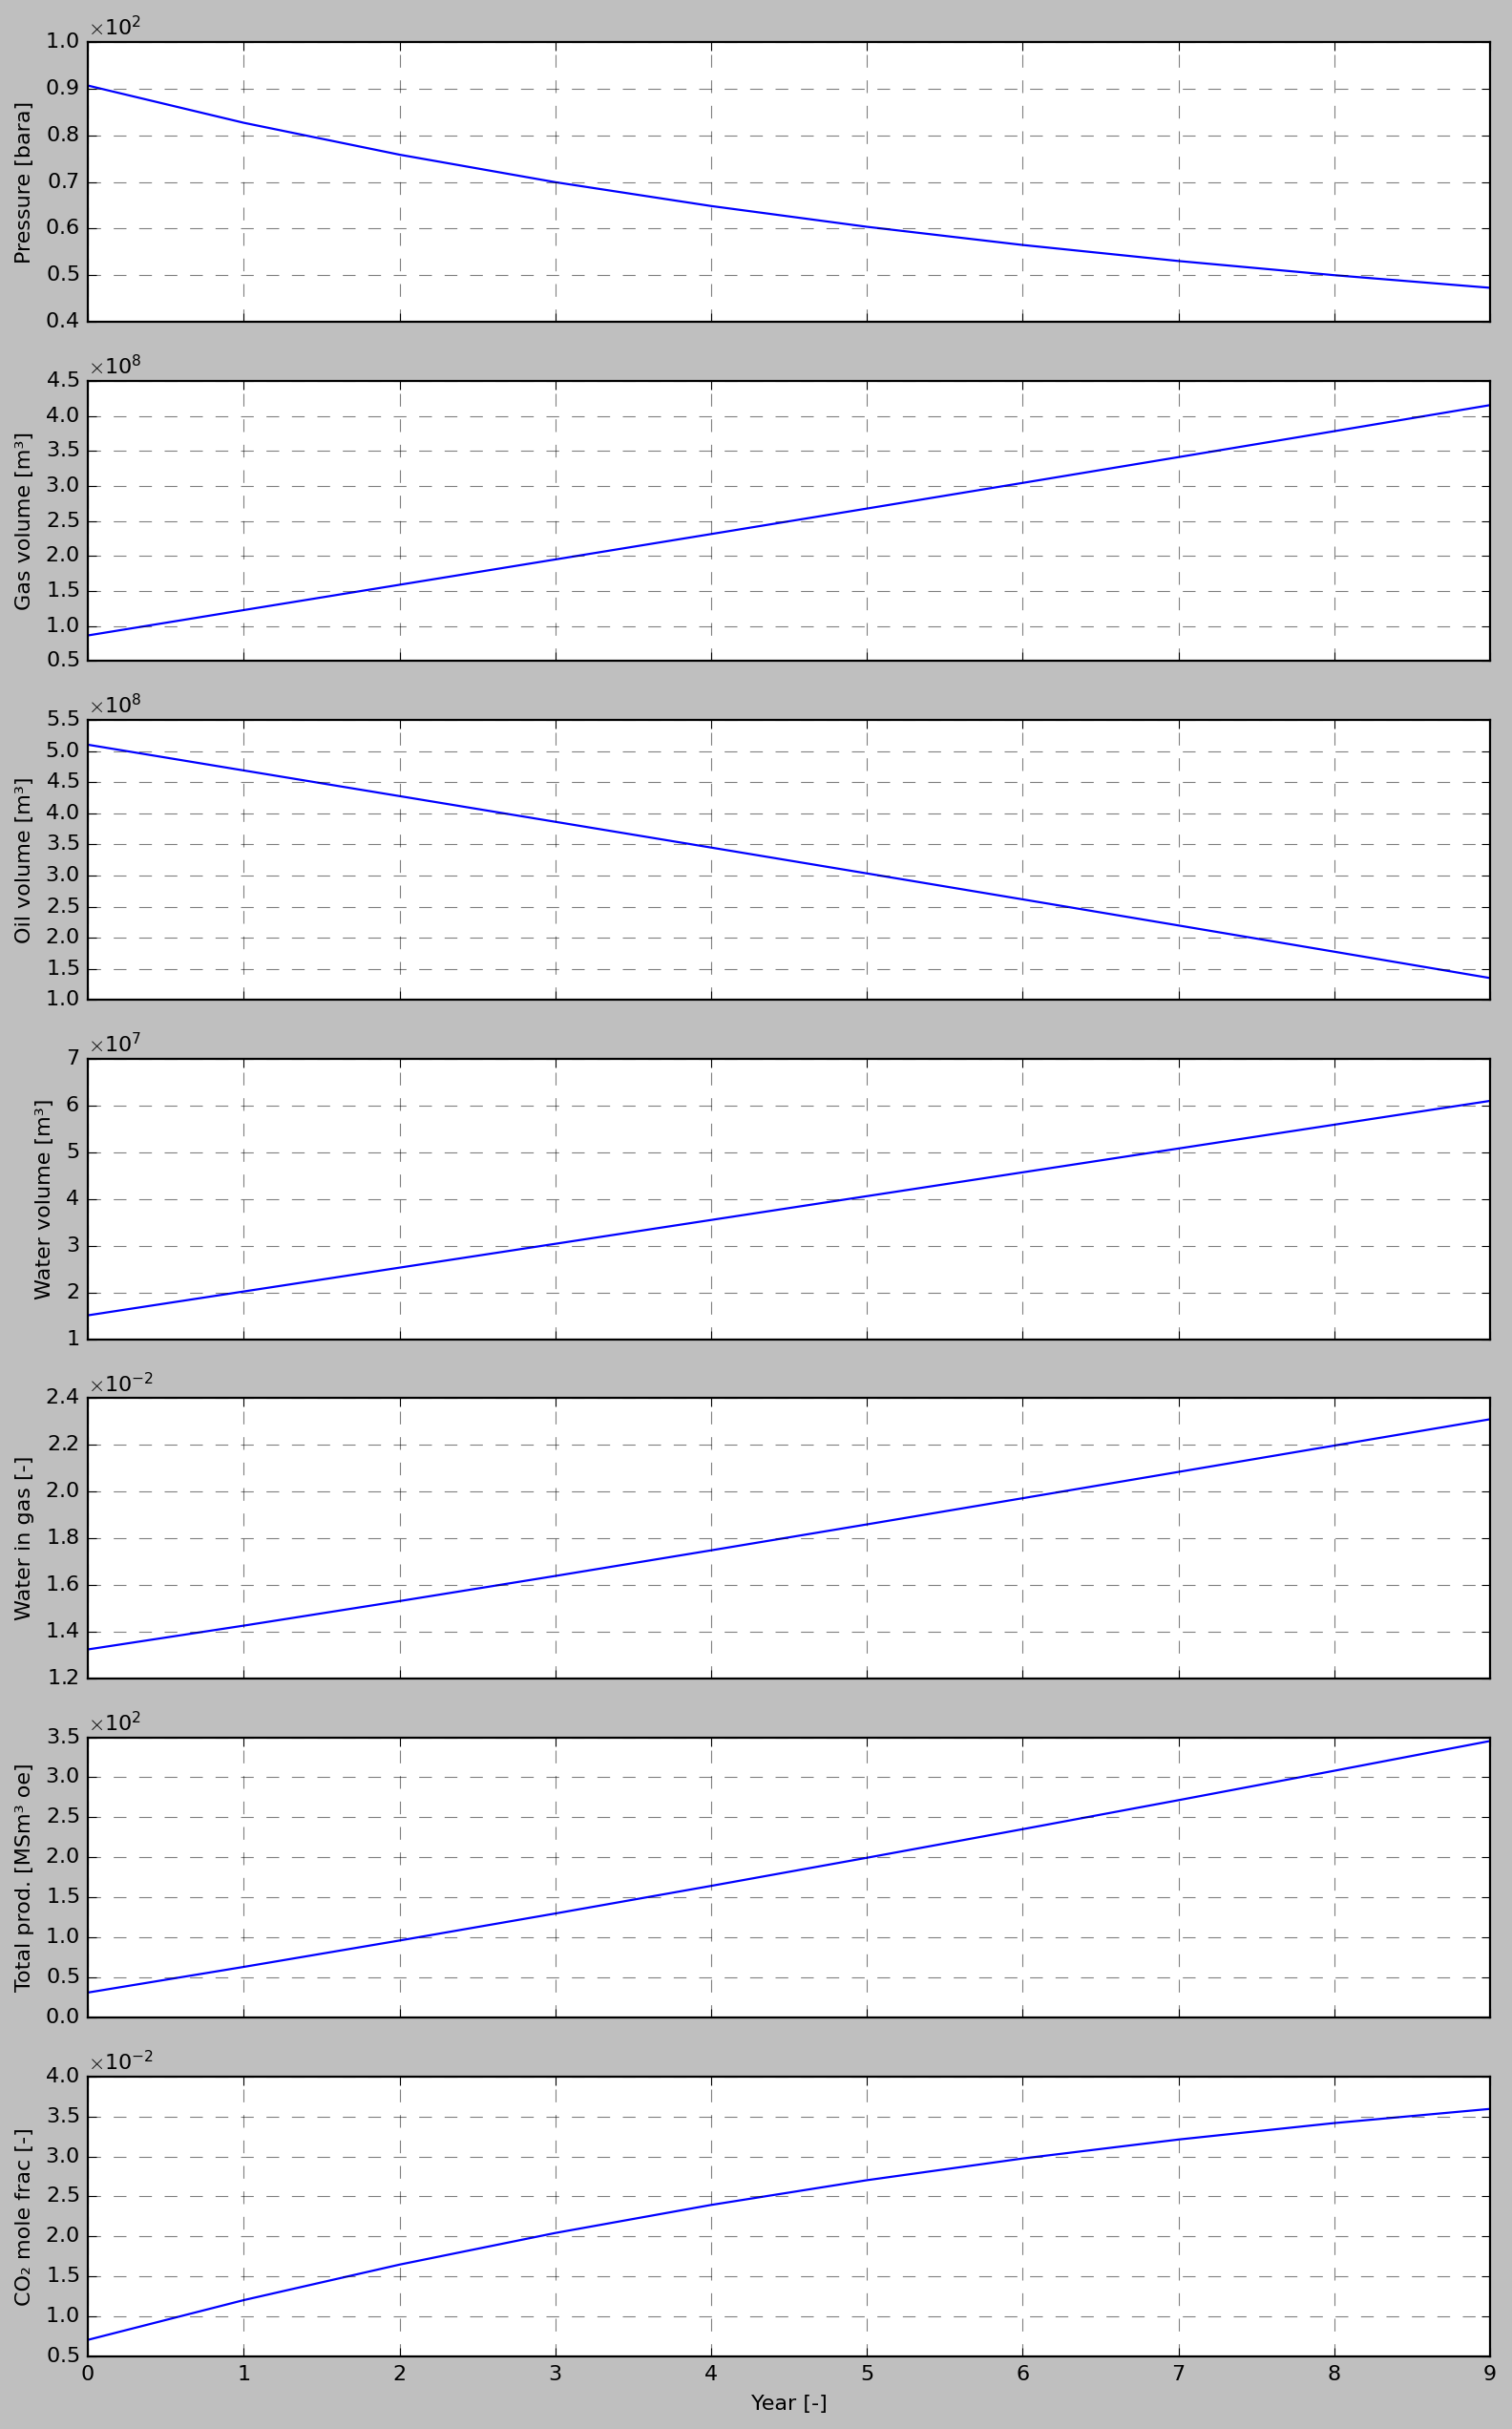

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

# High resolution for Colab
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['axes.grid'] = True

fig, axs = plt.subplots(7, 1, figsize=(10, 16), sharex=True)

def format_axis(ax):
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(True, linestyle='--', alpha=0.5)

axs[0].plot(time, pressure)
axs[0].set_ylabel('Pressure [bara]')
format_axis(axs[0])

axs[1].plot(time, gasvolume)
axs[1].set_ylabel('Gas volume [m³]')
format_axis(axs[1])

axs[2].plot(time, oilvolume)
axs[2].set_ylabel('Oil volume [m³]')
format_axis(axs[2])

axs[3].plot(time, watervolume)
axs[3].set_ylabel('Water volume [m³]')
format_axis(axs[3])

axs[4].plot(time, wateringas)
axs[4].set_ylabel('Water in gas [-]')
format_axis(axs[4])

axs[5].plot(time, totalproducedoe)
axs[5].set_ylabel('Total prod. [MSm³ oe]')
format_axis(axs[5])

axs[6].plot(time, co2reservoirgas)
axs[6].set_ylabel('CO₂ mole frac [-]')
axs[6].set_xlabel('Year [-]')
format_axis(axs[6])

# Clean x ticks (only integers)
axs[6].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()
